<a href="https://colab.research.google.com/github/myczu/FundusCNN/blob/main/PyTorchCNNfundus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import torch
print("PyTorch version:", torch.__version__)
print("Number of GPUs:", torch.cuda.device_count())
print("GPU Name:", torch.cuda.get_device_name(0))
print("Is CUDA available:", torch.cuda.is_available())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

PyTorch version: 2.6.0+cu126
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 3070
Is CUDA available: True
Using device: cuda


In [ ]:

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt


In [ ]:
train_dir = r'train'
val_dir = r'val'
test_dir = r'test'

In [ ]:
# Funkcja do wyświetlenia przykładowych plików z podfolderów
def display_sample_files(directory, n=5):
    if not os.path.exists(directory):
        print(f"Ścieżka {directory} nie istnieje.")
        return

    print(f"Przykładowe pliki z folderu {directory}:")
    for subfolder in os.listdir(directory):
        subfolder_path = os.path.join(directory, subfolder)
        if os.path.isdir(subfolder_path):
            print(f"\nKlasa: {subfolder}")
            files = os.listdir(subfolder_path)[:n]  # Pobierz pierwsze n plików
            for file in files:
                print(f"  - {file}")

# Wyświetlenie przykładowych plików
print("Dane treningowe:")
display_sample_files(train_dir)

print("\nDane testowe:")
display_sample_files(test_dir)

print("\nDane testowe:")
display_sample_files(val_dir)


Dane treningowe:
Przykładowe pliki z folderu D:\DemoCNNfundus\final\train:

Klasa: disease
  - TRAINdiseaseColor (1).jpg
  - TRAINdiseaseColor (10).jpg
  - TRAINdiseaseColor (100).jpg
  - TRAINdiseaseColor (101).jpg
  - TRAINdiseaseColor (102).jpg

Klasa: health
  - TRAINhealthColor (1).jpg
  - TRAINhealthColor (10).jpg
  - TRAINhealthColor (100).jpg
  - TRAINhealthColor (101).jpg
  - TRAINhealthColor (102).jpg

Dane testowe:
Przykładowe pliki z folderu D:\DemoCNNfundus\final\test:

Klasa: disease
  - TESTdiseaseColor (1).jpg
  - TESTdiseaseColor (10).jpg
  - TESTdiseaseColor (11).jpg
  - TESTdiseaseColor (12).jpg
  - TESTdiseaseColor (13).jpg

Klasa: health
  - TESThealthColor (1).jpg
  - TESThealthColor (10).jpg
  - TESThealthColor (11).jpg
  - TESThealthColor (12).jpg
  - TESThealthColor (13).jpg

Dane testowe:
Przykładowe pliki z folderu D:\DemoCNNfundus\final\val:

Klasa: disease
  - VALdiseaseColor (1).jpg
  - VALdiseaseColor (10).jpg
  - VALdiseaseColor (11).jpg
  - VALdiseaseCo

Dane treningowe:
Dane treningowe: Liczba obrazów: 2058
Dane treningowe: (2058, 512, 512, 3)


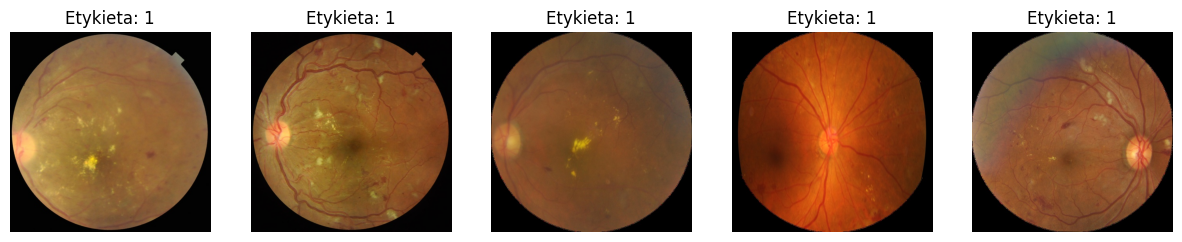


Dane walidacyjne:
Dane walidacyjne: Liczba obrazów: 438
Dane walidacyjne: (438, 512, 512, 3)


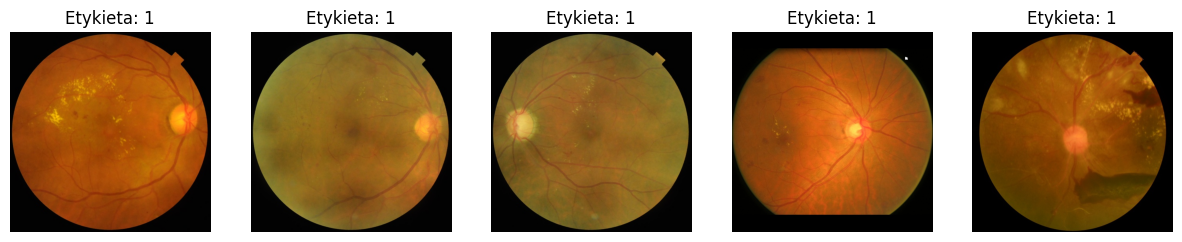


Dane testowe:
Dane testowe: Liczba obrazów: 360
Dane testowe: (360, 512, 512, 3)


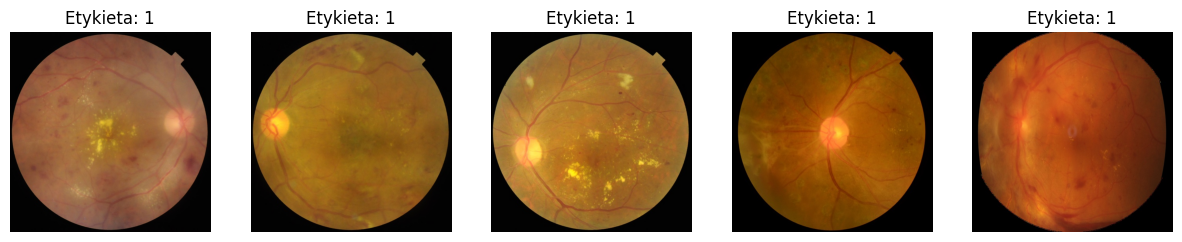

In [ ]:
# Komórka 3: Funkcja do wczytywania obrazów (512x512 JPG) oraz etykiet

# Definicja niestandardowego datasetu
class FundusDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Ścieżka do katalogu (train, val lub test), w którym znajdują się podfoldery "healthy" i "disease".
            transform (callable, optional): Funkcja transformująca obraz (np. augmentacje, ToTensor itd.).
        """
        self.root_dir = root_dir
        self.transform = transform
        self.data = []  # lista krotek (ścieżka_do_pliku, etykieta)
        # Mapowanie etykiet: healthy -> 0, disease -> 1
        self.class_map = {'health': 0, 'disease': 1}

        # Przechodzimy przez podfoldery (klasy)
        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                # Pobieramy tylko pliki JPG (możesz rozszerzyć do innych formatów, jeśli potrzeba)
                for file in os.listdir(class_path):
                    if file.lower().endswith('.jpg'):
                        file_path = os.path.join(class_path, file)
                        self.data.append((file_path, self.class_map[class_name]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path, label = self.data[index]
        # Otwieramy obraz, wymuszamy konwersję do RGB
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Funkcja pomocnicza do wyświetlenia informacji o zbiorze danych
def display_dataset_info(dataset, dataset_name="Dataset"):
    """
    Wyświetla liczbę obrazów oraz rozmiar przykładowego obrazu.
    Przykład wyjścia:
      Dane treningowe: Liczba obrazów: 2058
      Dane treningowe: (2058, 512, 512, 3)
    """
    print(f"{dataset_name}: Liczba obrazów: {len(dataset)}")
    # Pobieramy przykładowy obraz (indeks 0)
    img, _ = dataset[0]
    # Jeśli obraz jest tensorem (np. po ToTensor) – tensor ma kształt (C, H, W)
    if isinstance(img, torch.Tensor):
        # Zamieniamy na numpy i transponujemy do (H, W, C)
        img_np = img.numpy().transpose(1, 2, 0)
    else:
        img_np = np.array(img)
    h, w, c = img_np.shape
    print(f"{dataset_name}: ({len(dataset)}, {h}, {w}, {c})")

# Funkcja do wizualizacji przykładowych obrazów
def show_sample_images(dataset, n=5):
    """
    Wyświetla n przykładowych obrazów ze zbioru danych wraz z ich etykietami.
    """
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i in range(n):
        img, label = dataset[i]
        # Jeśli obraz jest tensorem, przenosimy do formatu (H,W,C)
        if isinstance(img, torch.Tensor):
            img_np = img.numpy().transpose(1, 2, 0)
            # Jeśli wartości są w zakresie [0,1], można je bezpośrednio wyświetlić
        else:
            img_np = np.array(img)
        axes[i].imshow(img_np)
        axes[i].set_title(f"Etykieta: {label}")
        axes[i].axis('off')
    plt.show()

# Przyjmujemy, że na tym etapie nie stosujemy jeszcze augmentacji – przynajmniej dla wyświetlania danych

basic_transform = transforms.Compose([
    transforms.ToTensor()
])

# Wczytujemy zbiory danych
train_dataset = FundusDataset(train_dir, transform=basic_transform)
val_dataset   = FundusDataset(val_dir, transform=basic_transform)
test_dataset  = FundusDataset(test_dir, transform=basic_transform)

# Wyświetlenie informacji o danych
print("Dane treningowe:")
display_dataset_info(train_dataset, "Dane treningowe")
show_sample_images(train_dataset, n=5)

print("\nDane walidacyjne:")
display_dataset_info(val_dataset, "Dane walidacyjne")
show_sample_images(val_dataset, n=5)

print("\nDane testowe:")
display_dataset_info(test_dataset, "Dane testowe")
show_sample_images(test_dataset, n=5)


Liczba próbek w oryginalnym zbiorze (trening): [1230  828]
Liczba wag (rozszerzony zbiór): 16464
Oczekiwana liczba przykładów: 16464
Batch X shape: torch.Size([32, 3, 512, 512]), Batch y shape: torch.Size([32])

Przykładowe obrazy po augmentacji:


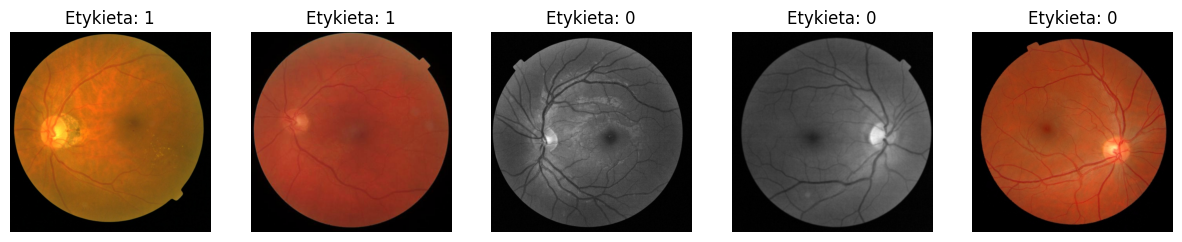

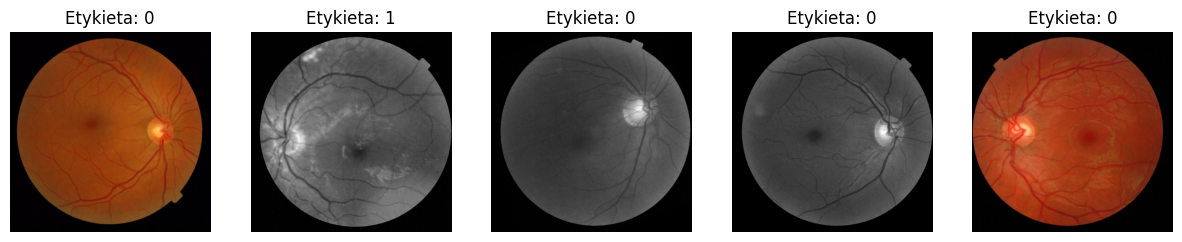

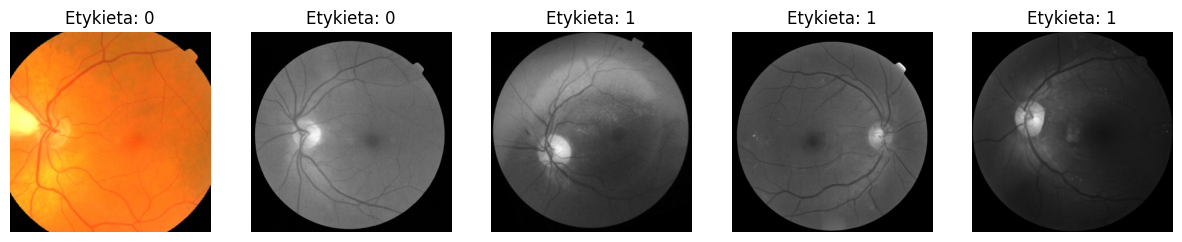

In [ ]:
#augmentacja

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
import os


# Przykładowa definicja oryginalnego zbioru danych.


class FundusDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        data_dir: katalog z obrazami (przykładowo) – implementacja zależy od struktury danych
        transform: funkcja transformująca obraz (jeśli ustawiona, zwraca już tensor)
        """
        self.data = []  # lista krotek (obraz, etykieta)
        self.transform = transform

        # Przykładowa implementacja – zakładamy, że w data_dir mamy dwa podfoldery:
        # "healthy" i "disease". Obrazy w "healthy" będą miały etykietę 0, a w "disease" etykietę 1.
        for label_name, label in [("health", 0), ("disease", 1)]:
            folder = os.path.join(data_dir, label_name)
            if os.path.isdir(folder):
                for fname in os.listdir(folder):
                    if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(folder, fname)
                        # Otwieramy obraz przy każdym dostępie – lub możesz zapisywać ścieżki
                        # i otwierać obraz w metodzie __getitem__
                        self.data.append((img_path, label))

    def __getitem__(self, index):
        img_path, label = self.data[index]
        # Otwórz obraz – zakładamy, że obrazy są w formacie PIL
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.data)


# 1. Definicja funkcji augmentujących.
# Każda funkcja przyjmuje obraz (PIL Image) i zwraca tensor.
def identity(img):
    """Oryginalny obraz bez zmian."""
    return transforms.ToTensor()(img)

def rotate_20(img):
    """Obrót o stały kąt 20°."""
    img_rot = TF.rotate(img, 20)
    return transforms.ToTensor()(img_rot)

def horizontal_flip(img):
    """Odbicie lustrzane w poziomie."""
    img_hf = TF.hflip(img)
    return transforms.ToTensor()(img_hf)

def rotate_and_hflip(img):
    """Obrót o 20° i następnie flip poziomy."""
    img_rot = TF.rotate(img, 20)
    img_rhf = TF.hflip(img_rot)
    return transforms.ToTensor()(img_rhf)

def zoom_20(img):
    """
    Powiększenie (zoom) – używamy transformacji affine z scale > 1.
    Aby wynik miał oryginalne rozmiary, wykonujemy resize.
    """
    # Najpierw affine z scale=1.2, potem center crop lub resize do oryginalnych wymiarów
    orig_size = img.size  # (width, height)
    img_zoom = TF.affine(img, angle=0, translate=(0, 0), scale=1.2, shear=0)
    # Przytnij do oryginalnych wymiarów (prosty center crop)
    w, h = img_zoom.size
    left = (w - orig_size[0]) // 2
    top = (h - orig_size[1]) // 2
    img_zoom = img_zoom.crop((left, top, left + orig_size[0], top + orig_size[1]))
    return transforms.ToTensor()(img_zoom)

def gaussian_blur(img):
    """Rozmycie gaussowskie – używamy filtra PIL."""
    img_blur = img.filter(ImageFilter.GaussianBlur(radius=1))
    return transforms.ToTensor()(img_blur)

def vertical_flip(img):
    """Odbicie lustrzane w pionie."""
    img_vf = TF.vflip(img)
    return transforms.ToTensor()(img_vf)

def color_jitter_aug(img):
    """Zmiana parametrów kolorystycznych (jasność, kontrast, nasycenie, odcień)."""
    jitter = transforms.ColorJitter(
        brightness=0.1,
        contrast=0.1,
        saturation=0.1,
        hue=0.02
    )
    img_jitter = jitter(img)
    return transforms.ToTensor()(img_jitter)


# 2. Lista funkcji augmentujących – decydujemy, które transformacje chcemy zastosować.

aug_functions = [
    identity,          # 1) Oryginał
    rotate_20,         # 2) Obrót o 20°
    horizontal_flip,   # 3) Flip poziomy
    rotate_and_hflip,  # 4) Obrót + flip poziomy
    zoom_20,           # 5) Zoom o 20%
    gaussian_blur,     # 6) Rozmycie gaussowskie
    vertical_flip,     # 7) Flip pionowy
    color_jitter_aug   # 8) Color jitter
]


# 3. Opakowanie oryginalnego zbioru w dataset z augmentacją.


class AugmentedDataset(Dataset):
    def __init__(self, base_dataset, augmentation_funcs):
        """
        base_dataset: oryginalny dataset (np. FundusDataset) – musi zwracać obraz PIL i etykietę.
        augmentation_funcs: lista funkcji przyjmujących obraz PIL i zwracających tensor.
        """
        self.base_dataset = base_dataset
        self.aug_funcs = augmentation_funcs
        self.n_base = len(base_dataset)
        self.n_aug = len(augmentation_funcs)

    def __len__(self):
        # Całkowita liczba przykładów = liczba oryginalnych obrazków * liczba funkcji augmentujących.
        return self.n_base * self.n_aug

    def __getitem__(self, idx):
        # Wyznaczamy, który obrazek i która augmentacja mają zostać użyte:
        base_idx = idx % self.n_base         # indeks oryginalnego obrazka
        aug_idx  = idx // self.n_base         # numer funkcji augmentującej
        img, label = self.base_dataset[base_idx]
        img_aug = self.aug_funcs[aug_idx](img)
        return img_aug, label


# 4. Przygotowanie oryginalnego zbioru treningowego.
# Ustawiamy transform=None, aby uzyskać obraz PIL i móc na nim wykonywać nasze transformacje.

train_dir = r'D:\DemoCNNfundus\final\train'

train_dataset = FundusDataset(train_dir, transform=None)

# Tworzymy rozszerzony (augmentowany) zbiór
augmented_train_dataset = AugmentedDataset(base_dataset=train_dataset, augmentation_funcs=aug_functions)


# 5. Obliczanie wag dla niezbalansowanego rozkładu klas.

# Pobieramy etykiety z oryginalnego zbioru:
base_labels = [label for _, label in train_dataset.data]
class_counts = np.bincount(base_labels)  # np. [liczba healthy, liczba disease]
print("Liczba próbek w oryginalnym zbiorze (trening):", class_counts)

# Waga dla klasy = odwrotność liczby przykładów tej klasy
class_weights = 1.0 / class_counts

# Dla rozszerzonego zbioru powielamy wagę każdego obrazu tyle razy, ile mamy augmentacji.
n_aug = len(aug_functions)
aug_sample_weights = []
for label in base_labels:
    for _ in range(n_aug):
        aug_sample_weights.append(class_weights[label])

# Sprawdzamy rozmiar listy wag – powinien być równy liczbie przykładów w augmented_train_dataset.
print("Liczba wag (rozszerzony zbiór):", len(aug_sample_weights))
print("Oczekiwana liczba przykładów:", len(train_dataset) * n_aug)

# Możesz ustalić num_samples – na przykład wykorzystując pełny rozmiar zbioru lub inną strategię.
num_samples = len(aug_sample_weights)  # lub np. int(2 * max(class_counts) * n_aug)

# Tworzymy sampler
sampler = WeightedRandomSampler(aug_sample_weights, num_samples=num_samples, replacement=True)


# 6. DataLoader – korzystamy z naszego sampler’a dla augmented_train_dataset.

train_loader = DataLoader(augmented_train_dataset, batch_size=32, sampler=sampler)


# 7. Funkcja pomocnicza do wizualizacji kilku augmentowanych próbek.

def show_augmented_samples(loader, n=5):
    X_batch, y_batch = next(iter(loader))
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i in range(n):
        # Konwersja tensora (C, H, W) na format (H, W, C)
        img = X_batch[i].permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].set_title(f"Etykieta: {y_batch[i].item()}")
        axes[i].axis('off')
    plt.show()


# 8. Przykład wyświetlenia jednego batcha augmentowanych obrazków.

for X_batch, y_batch in train_loader:
    print(f"Batch X shape: {X_batch.shape}, Batch y shape: {y_batch.shape}")
    break

print("\nPrzykładowe obrazy po augmentacji:")
show_augmented_samples(train_loader, n=5)
show_augmented_samples(train_loader, n=5)
show_augmented_samples(train_loader, n=5)


In [ ]:
# Ustalenie urządzenia (GPU, jeśli dostępne)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Uruchamiamy na urządzeniu:", device)

# Wczytanie pretrenowanego modelu ResNet50
model = models.resnet50(pretrained=True)

# Zamrażamy wszystkie warstwy – trenować będziemy tylko ostatnią warstwę FC
for param in model.parameters():
    param.requires_grad = False

# Dostosowanie ostatniej warstwy (fully connected) do dwóch klas
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 2)

# Przeniesienie modelu na wybrane urządzenie (GPU/CPU)
model = model.to(device)
print(model)

Uruchamiamy na urządzeniu: cuda


d:\DemoCNNfundus\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\DemoCNNfundus\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt



# Definicja funkcji straty
criterion = nn.CrossEntropyLoss()

# Optymalizujemy tylko parametry ostatniej warstwy (model.fc)
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

# Ustalamy liczbę epok treningowych
num_epochs = 10

# Listy do przechowywania strat i dokładności – przydatne przy wizualizacji
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # -----------------
    # Tryb treningowy
    # -----------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()                # zerowanie gradientów
        outputs = model(inputs)              # forward pass
        loss = criterion(outputs, labels)    # obliczenie straty
        loss.backward()                      # backpropagation
        optimizer.step()                     # aktualizacja wag

        # Sumujemy stratę – mnożymy przez liczbę przykładów w partii
        running_loss += loss.item() * inputs.size(0)
        # Obliczamy dokładność
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # -----------------
    # Tryb walidacyjny
    # -----------------
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    epoch_val_acc = val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    # Wyświetlamy wyniki dla bieżącej epoki
    print(f"Epoka {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")



Epoka 1/10 | Train Loss: 0.2944, Train Acc: 0.8802 | Val Loss: 0.2534, Val Acc: 0.8881
Epoka 2/10 | Train Loss: 0.2846, Train Acc: 0.8842 | Val Loss: 0.2281, Val Acc: 0.9064
Epoka 3/10 | Train Loss: 0.2621, Train Acc: 0.8957 | Val Loss: 0.3047, Val Acc: 0.8813
Epoka 4/10 | Train Loss: 0.2530, Train Acc: 0.8988 | Val Loss: 0.2693, Val Acc: 0.8950
Epoka 5/10 | Train Loss: 0.2535, Train Acc: 0.8980 | Val Loss: 0.3024, Val Acc: 0.8836
Epoka 6/10 | Train Loss: 0.2442, Train Acc: 0.9020 | Val Loss: 0.2169, Val Acc: 0.9110
Epoka 7/10 | Train Loss: 0.2406, Train Acc: 0.9042 | Val Loss: 0.2007, Val Acc: 0.9292
Epoka 8/10 | Train Loss: 0.2482, Train Acc: 0.8988 | Val Loss: 0.2073, Val Acc: 0.9224
Epoka 9/10 | Train Loss: 0.2366, Train Acc: 0.9057 | Val Loss: 0.1945, Val Acc: 0.9110
Epoka 10/10 | Train Loss: 0.2287, Train Acc: 0.9089 | Val Loss: 0.2074, Val Acc: 0.9155


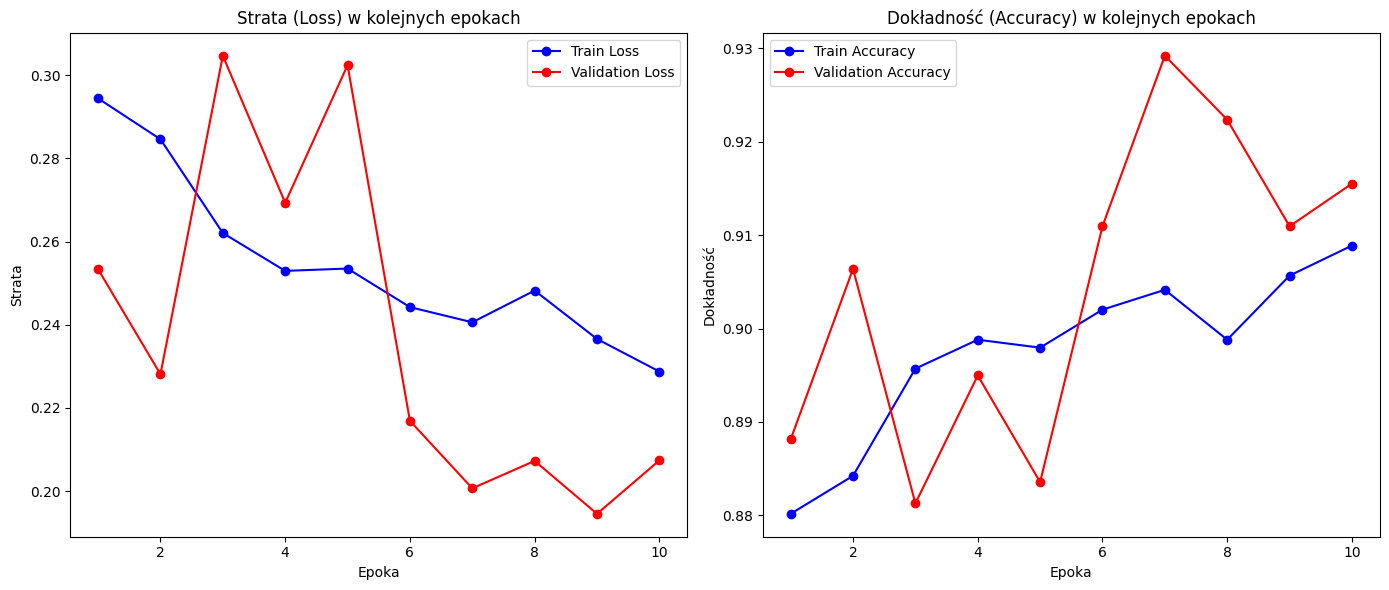

In [ ]:
import matplotlib.pyplot as plt

# Zakładamy, że zmienne train_losses, val_losses, train_accuracies, val_accuracies oraz num_epochs są już zdefiniowane

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(14, 6))

# Wykres strat (loss)
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.title('Strata (Loss) w kolejnych epokach')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()

# Wykres dokładności (accuracy)
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
plt.title('Dokładność (Accuracy) w kolejnych epokach')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()

plt.tight_layout()
plt.show()


Epoka 6/10 | Train Loss: 0.0137, Train Acc: 0.9948 | Val Loss: 0.1876, Val Acc: 0.9635
EarlyStopping counter: 5 out of 5
Early stopping!


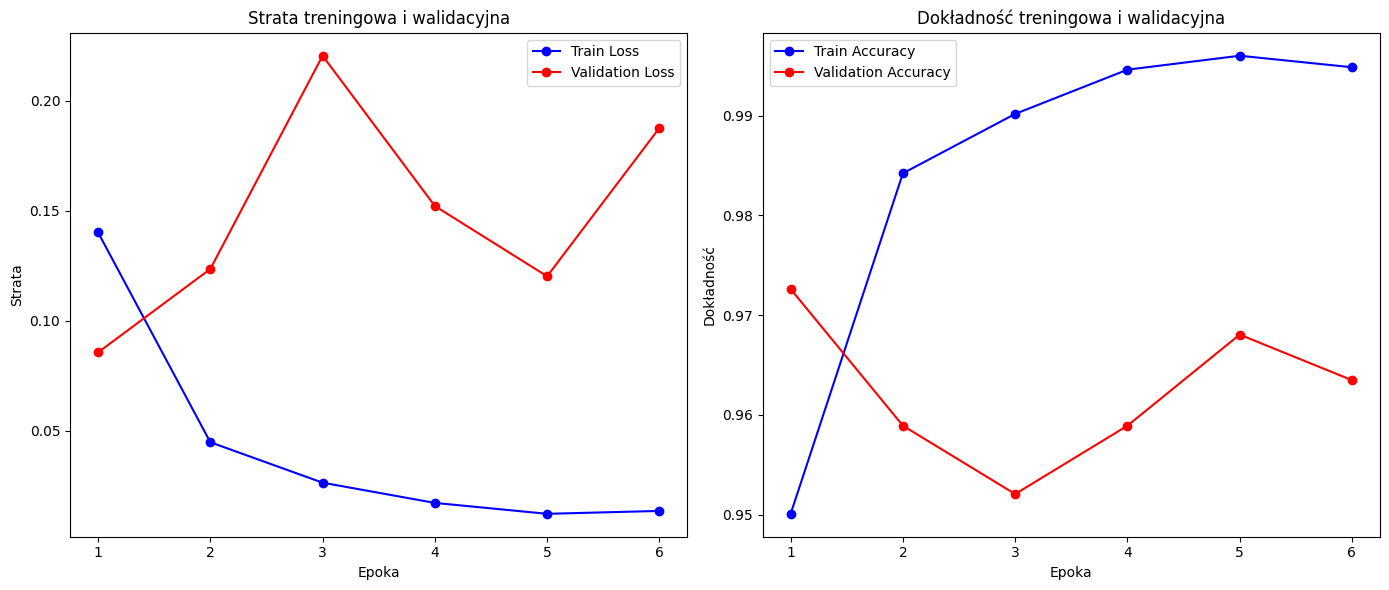

In [ ]:
import copy
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import clear_output


# 1. EarlyStopping – klasa pomocnicza

class EarlyStopping:
    """
    Klasa EarlyStopping monitoruje walidacyjną stratę i przerywa trening,
    gdy przez określoną liczbę epok (patience) nie nastąpi poprawa.
    """
    def __init__(self, patience=3, verbose=False, delta=0.001):
        """
        Args:
            patience (int): Liczba epok bez poprawy, po której trening zostanie przerwany.
            verbose (bool): Jeśli True, wypisuje komunikaty.
            delta (float): Minimalna zmiana w walidacyjnej stracie, aby uznać ją za poprawę.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_wts = copy.deepcopy(model.state_dict())
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0


# 2. Fine-tuning – odblokowanie wybranych warstw


for param in model.layer4.parameters():
    param.requires_grad = True


# 3. Konfiguracja optymalizatora z regularizacją (weight decay)

# Używamy mniejszego learning rate dla fine-tuningu oraz L2 regularizacji (weight_decay)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Definicja funkcji straty pozostaje bez zmian
criterion = nn.CrossEntropyLoss()


# 4. Pętla treningowa z Early Stopping

num_epochs = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

early_stopping = EarlyStopping(patience=5, verbose=True, delta=0.0005)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Walidacja
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    epoch_val_acc = val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    # Czyszczenie poprzedniego outputu dla efektu live update
    clear_output(wait=True)
    print(f"Epoka {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    # Sprawdzamy warunek early stopping
    early_stopping(epoch_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping!")
        break

# Ładujemy najlepsze wagi zapisane przez EarlyStopping
model.load_state_dict(early_stopping.best_model_wts)


# 5. Wizualizacja wyników – wykresy strat i dokładności

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))

# Wykres strat (loss)
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.title('Strata treningowa i walidacyjna')
plt.legend()

# Wykres dokładności (accuracy)
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.title('Dokładność treningowa i walidacyjna')
plt.legend()

plt.tight_layout()
plt.show()


d:\DemoCNNfundus\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\DemoCNNfundus\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Macierz pomyłek:
[[171   1]
 [  0 172]]

Raport klasyfikacji:
              precision    recall  f1-score   support

     disease    1.00000   0.99419   0.99708       172
      health    0.99422   1.00000   0.99710       172

    accuracy                        0.99709       344
   macro avg    0.99711   0.99709   0.99709       344
weighted avg    0.99711   0.99709   0.99709       344

Dokładność na zbiorze testowym: 99.7093%


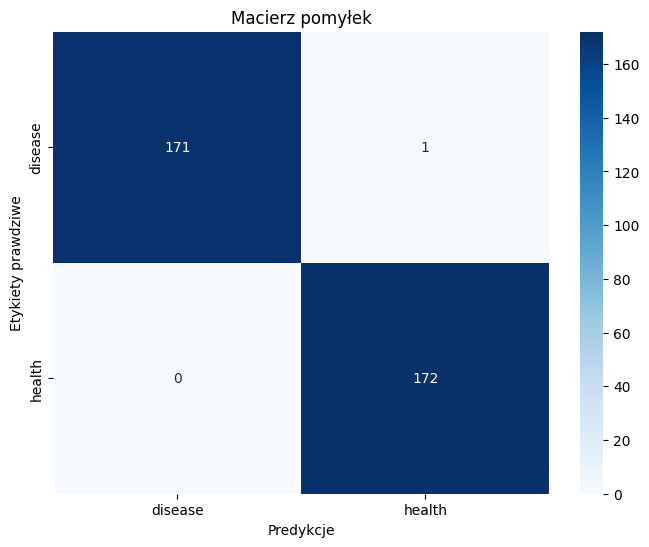

In [ ]:
# Komórka 7: Ocena modelu na zbiorze testowym
import torch
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models

# Ustawienie urządzenia (GPU, jeśli dostępne)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definicja transformacji (upewnij się, że odpowiadają tym stosowanym podczas treningu)
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    # Jeśli stosowano normalizację podczas treningu, odkomentuj poniższą linię:
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Ścieżka do zbioru testowego
test_dir = r'D:\DemoCNNfundus\final\test'

# Ładowanie zbioru testowego przy użyciu ImageFolder (struktura folderu: podfoldery odpowiadają etykietom)
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Załadowanie modelu (przykład dla ResNet50 z modyfikowaną ostatnią warstwą)
model = models.resnet50(pretrained=False)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 2)
model.load_state_dict(torch.load(r'D:\DemoCNNfundus\FINALfundus_resnet50.pth', map_location=device))
model = model.to(device)
model.eval()

# Przechwytywanie predykcji i etykiet dla całego zbioru testowego
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        # Odwrócenie predykcji (dla dwóch klas)
        preds = 1 - preds
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Obliczenie macierzy pomyłek
cm = confusion_matrix(all_labels, all_preds)

# Generowanie raportu klasyfikacji (metryki: precision, recall, f1-score, support)
report = classification_report(all_labels, all_preds, target_names=test_dataset.classes, digits=5)

# Obliczenie dokładności
accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels) * 100

print("Macierz pomyłek:")
print(cm)
print("\nRaport klasyfikacji:")
print(report)
print(f"Dokładność na zbiorze testowym: {accuracy:.4f}%")

# Wizualizacja macierzy pomyłek za pomocą heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel("Predykcje")
plt.ylabel("Etykiety prawdziwe")
plt.title("Macierz pomyłek")
plt.show()


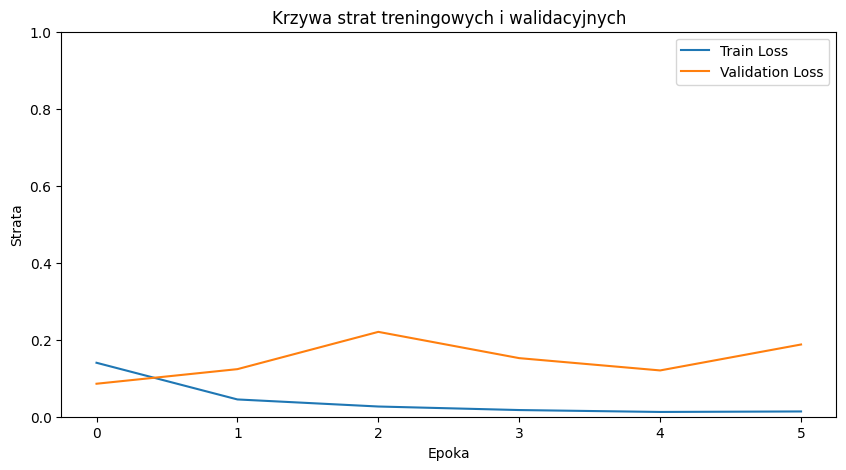

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.title('Krzywa strat treningowych i walidacyjnych')
plt.ylim(0, 1)  # Ustawienie zakresu osi y od 0 do 1
plt.legend()
plt.show()

In [ ]:
# Zapis wytrenowanego modelu
model_path = 'FINALfundus_resnet50.pth'
torch.save(model.state_dict(), model_path)
print(f"Model zapisany do pliku: {model_path}")

Model zapisany do pliku: FINALfundus_resnet50.pth


Real Class: disease


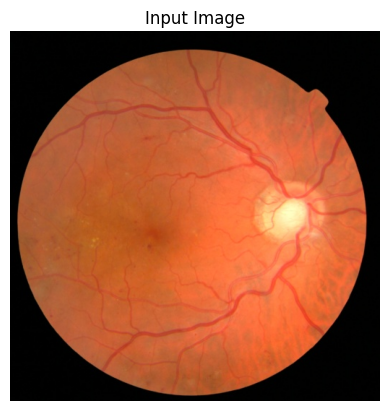

Probabilities:
non-diabetic: 0.01%
diabetic: 99.99%


In [ ]:
import matplotlib.pyplot as plt
import os
import torch
from torchvision import transforms, models
from PIL import Image
import numpy as np


# Upewnij się, że korzystasz z właściwego urządzenia (GPU lub CPU)
device = torch.device("cpu")

# Jeśli model nie został jeszcze załadowany, odtwórz jego architekturę i ładuj zapisany stan:
# (Zakładamy, że podczas treningu używaliśmy modelu ResNet50 z modyfikowaną ostatnią warstwą)
model = models.resnet50(pretrained=False)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 2)
model.load_state_dict(torch.load('FINALfundus_resnet50.pth', map_location=device))
model = model.to(device)
model.eval()  # Ustawienie modelu w tryb ewaluacji

# Definicja mapowania etykiet
# Nowe mapowanie etykiet
class_mapping = {0: 'non-diabetic', 1: 'diabetic'}


# Podaj ścieżkę do obrazu, który chcesz przetestować (zmień na odpowiednią)
image_path = r"testowanko.jpg"

import os

def get_image_paths(image_path):
    if os.path.isdir(image_path):  # Jeśli podana ścieżka to folder
        image_paths = [os.path.join(image_path, f) for f in os.listdir(image_path)
                       if f.lower().endswith(('.jpg', '.jpeg', '.png', '.jfif'))]
    elif os.path.isfile(image_path) and image_path.lower().endswith(('.jpg', '.jpeg', '.png', '.jfif')):
        # Jeśli podana ścieżka to pojedynczy plik
        image_paths = [image_path]
    else:
        image_paths = []  # Jeśli ścieżka nie jest poprawnym plikiem ani folderem

    return image_paths

# Przykładowe użycie

image_files = get_image_paths(image_path)

#print(image_files)


# Podaj prawdziwą klasę obrazu (do celów prezentacyjnych)
real_class = "disease" #"healthy"
print("Real Class:", real_class)

# Wczytaj i wyświetl obraz
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
plt.title("Input Image")
plt.axis('off')
plt.show()

# Definiujemy transformacje, tak jak podczas treningu – tutaj resize do 512x512 i konwersja do tensora
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    # Jeśli podczas treningu stosowano normalizację, dodaj ją tutaj (np. transforms.Normalize(mean, std))
])

# Przetwarzamy obraz
input_tensor = preprocess(image)  # kształt: (C, H, W)
input_tensor = input_tensor.unsqueeze(0)  # dodajemy wymiar batcha, kształt: (1, C, H, W)
input_tensor = input_tensor.to(device)

# Przeprowadzamy inferencję
with torch.no_grad():
    outputs = model(input_tensor)  # uzyskujemy logity o wymiarze (1, 2)
    # Obliczamy prawdopodobieństwa przy użyciu softmax
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    probabilities_np = probabilities.cpu().numpy().squeeze()  # zamieniamy na numpy array
    predicted_class_index = np.argmax(probabilities_np)
    predicted_class = class_mapping[predicted_class_index]

#print("Predicted Class:", predicted_class)
print("Probabilities:")
print("non-diabetic: {:.2f}%".format(100 * probabilities_np[0]))
print("diabetic: {:.2f}%".format(100 * probabilities_np[1]))


Znaleziono 5 obrazów w folderze 'TESTfinal'.


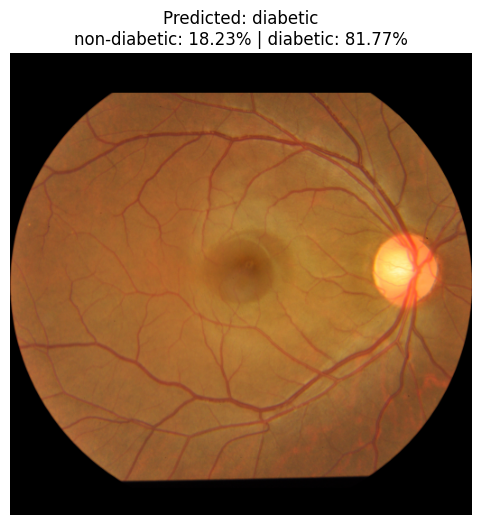

BEH-121.png


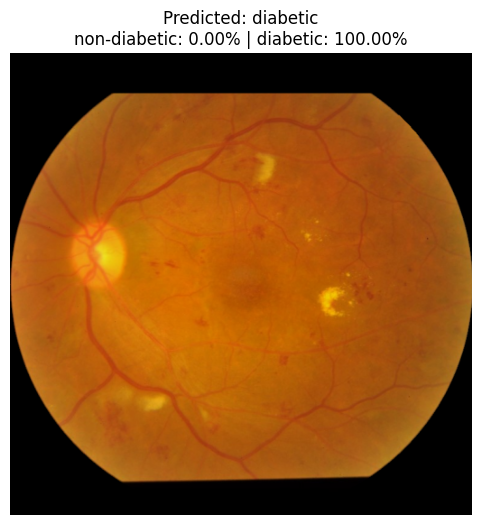

BEH-130.png


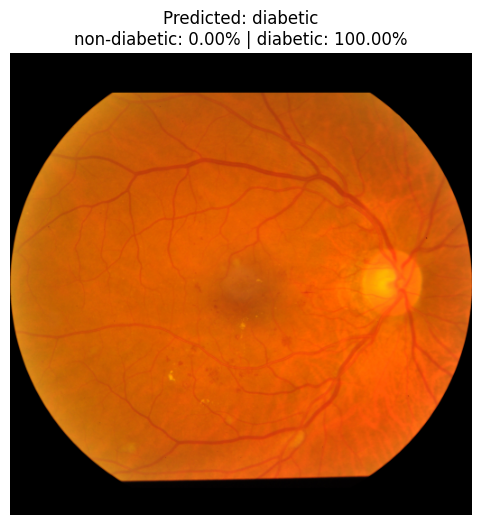

BEH-188.png


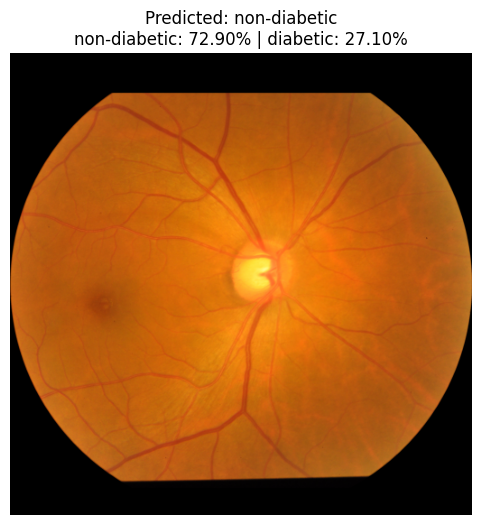

BEH-196.png


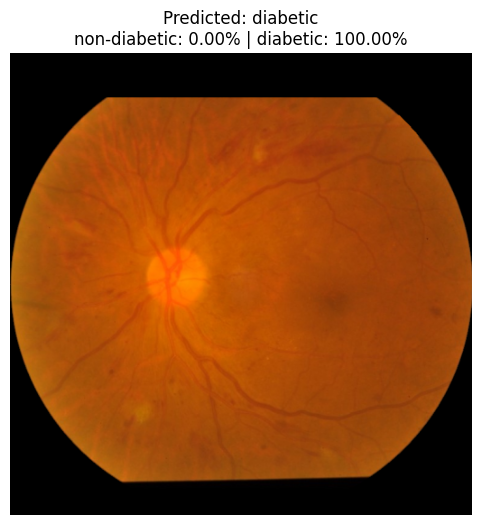

BEH-281.png


In [ ]:
#DLA FOLDERU!
import matplotlib.pyplot as plt
import os
import torch
from torchvision import transforms, models
from PIL import Image
import numpy as np

# Ustalenie urządzenia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Załadowanie modelu (przykład dla ResNet50 z modyfikowaną ostatnią warstwą)
model = models.resnet50(pretrained=False)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 2)
model.load_state_dict(torch.load('FINALfundus_resnet50.pth', map_location=device))
model = model.to(device)
model.eval()  # Ustawienie modelu w tryb ewaluacji

# Mapowanie etykiet
class_mapping = {0: 'non-diabetic', 1: 'diabetic'}

# Definicja transformacji (musi odpowiadać tym używanym podczas treningu)
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    # Jeśli podczas treningu stosowano normalizację, np.:
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Ścieżka do folderu z obrazami, które chcesz przetestować
folder_path = rtest_dir = r"TESTfinal" # Zmień tę ścieżkę na odpowiednią

# Pobranie listy plików z rozszerzeniem .jpg, .jpeg lub .png
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
               if f.lower().endswith(('.jpg', '.jpeg', '.png' , '.jfif'))]

print(f"Znaleziono {len(image_files)} obrazów w folderze '{folder_path}'.")

# Iteracja po wszystkich obrazach w folderze
for image_path in image_files:
    # Wczytanie obrazu i przekształcenie do formatu RGB
    image = Image.open(image_path).convert('RGB')

    # Przetwarzanie obrazu
    input_tensor = preprocess(image)          # kształt: (C, H, W)
    input_tensor = input_tensor.unsqueeze(0)    # dodanie wymiaru batcha: (1, C, H, W)
    input_tensor = input_tensor.to(device)

    # Inferencja - bez obliczania gradientów
    with torch.no_grad():
        outputs = model(input_tensor)  # Wyjście modelu, tzw. logity
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        probabilities_np = probabilities.cpu().numpy().squeeze()
        predicted_class_index = np.argmax(probabilities_np)
        predicted_class = class_mapping[predicted_class_index]

    # Wypisanie wyników
    #print("Obraz:", image_path)
    #print("Predicted Class:", predicted_class)
    #print("Probabilities: non-diabetic: {:.2f}% | diabetic: {:.2f}%".format(100 * probabilities_np[0],
    #                                                                  100 * probabilities_np[1]))
    #print("-" * 50)

    # Wyświetlenie podglądu obrazu z informacjami
    file_name = os.path.basename(image_path)
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}\nnon-diabetic: {100 * probabilities_np[0]:.2f}% | diabetic: {100 * probabilities_np[1]:.2f}%")
    plt.axis('off')
    plt.show()
    print(file_name)